In [1]:
import argparse
from lib2to3.pgen2 import token
import logging
import os
import random
from dataclasses import dataclass
from itertools import chain
from typing import Optional, Union
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

import datasets
import torch
from torch.nn.modules.sparse import Embedding
import torch.nn as nn
from torch.nn.modules.linear import Linear
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from train import DataCollatorForMultipleChoice
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import transformers
from accelerate import Accelerator
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    PreTrainedTokenizerBase,
    default_data_collator,
    DataCollatorForSeq2Seq,
    AdamW,
    SchedulerType,
    get_scheduler,
    set_seed,
)
from transformers.file_utils import PaddingStrategy

logger = logging.getLogger(__name__)


/opt/conda/envs/tz/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {}
args["dataset_name"] = "seven_prompts003.parquet.gzip"
args["eval_name"] = "miniprompts002_eval.parquet.gzip"
args["model_name_or_path"] = "bigscience/T0_3B"
args["output_dir"] = "/home/gikok/output"
args["num_train_epochs"] = 1
args["per_device_train_batch_size"] = 16
args["per_device_eval_batch_size"] = 16
args["freeze_encoder"] = True
args["learning_rate"] = 1e30
args["parallelize"] = False
args["seed"] = 42
args["pad_to_max_length"] = False
args["input_eos"] = False
args["target_max_length"] = 256
args["max_length"] = 512
args["num_warmup_steps"] = 0
args["debug"] = False
args["lr_scheduler_type"] = "linear"
args["num_shots"] = None
args["weight_decay"] = 0.0
args["gradient_checkpoint"] = False
args["gradient_accumulation_steps"] = 1
args["max_train_steps"] = None


def resample(model, layer, n_new):

    new_tensor = list(model.named_parameters())[layer][1].detach().cpu()

    for i in range(2048):
        val, bin = np.histogram(new_tensor[:-n_new, i], 10000)
        pdf = val / sum(val)
        cdf = np.cumsum(pdf)
        b = (bin[1:] + bin[:-1]) / 2
        new_tensor[-n_new:, i] = torch.tensor(
            np.interp(np.random.random(n_new), cdf, b)
        )
    data = list(model.named_parameters())[layer][1].data
    data[:, :] = new_tensor
# define the LightningModule
# class plModelClass(pl.LightningModule):
#     def __init__(self, model, args):
#         super().__init__()
#         self.model = model
#         self.args = args
#         self.learning_rate = args['learning_rate']

#     def training_step(self, batch, batch_idx):
#         # training_step defines the train loop.
#         # it is independent of forward
#         outputs = self.model(**batch)
#         loss = outputs.loss
#         # Logging to TensorBoard by default
#         self.log("train_loss", loss)
#         return loss

#     def configure_optimizers(self):

#         optimizer = AdamW(
#             [
#                 list(self.model.named_parameters())[0][1],
#                 list(self.model.named_parameters())[-1][1],
#             ],
#             lr=self.learning_rate,
#             weight_decay=0,
#         )

#         return optimizer

In [5]:
set_seed(args["seed"])

# Initialize the accelerator. We will let the accelerator handle device placement for us.
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

# Setup logging, we only want one process per machine to log things on the screen.

datasets.utils.logging.set_verbosity_error()
transformers.utils.logging.set_verbosity_error()

# Handle the output directory creation
os.makedirs(args["output_dir"], exist_ok=True)

# In distributed evaluation, the load_dataset function guarantee that only one local process can concurrently
# download the dataset.
if args["dataset_name"] is not None:
    data_files = {"train": args["dataset_name"]}
    raw_train_dataset = load_dataset("data", data_files=data_files, split="train")
else:
    raise ValueError("Please specify `args['dataset_name`.")

# Trim a number of evaluation training
if args["debug"]:
    raw_train_dataset = raw_train_dataset.select(
        range(min(100, len(raw_train_dataset)))
    )


model = AutoModelForSeq2SeqLM.from_pretrained(args["model_name_or_path"]).to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained(args["model_name_or_path"])

# get all item_no and add as tokens
items = pd.read_parquet("data/item_no_100.parquet.gzip")["item_no"].values.tolist()
# tokenizer.add_tokens(items)

# # then resize embeddings
# model.resize_token_embeddings(len(tokenizer))

# # resample shared embedding and lm_head layer
# resample(model, 0, len(items))
# resample(model, -1, len(items))


# Preprocessing the datasets.
# First we tokenize all the texts.
padding = "max_length" if args["pad_to_max_length"] else False


def tokenize_train(examples):
    input_texts = examples["input"]
    target_texts = examples["target"]

    model_inputs = tokenizer(
        input_texts,
        padding=padding,
        max_length=args["max_length"],
        truncation=True,
        add_special_tokens=args["input_eos"],
    )

    with tokenizer.as_target_tokenizer():
        tokenized_targets = tokenizer(
            target_texts,
            padding=padding,
            max_length=args["target_max_length"],
            truncation=True,
            add_special_tokens=False,
        )
        model_inputs["labels"] = [
            [(t if t != tokenizer.pad_token_id else -100) for t in targets]
            for targets in tokenized_targets["input_ids"]
        ]
    return model_inputs




train_dataset = raw_train_dataset.map(tokenize_train, batched=True)
train_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)


# Log a few random training:
for index in random.sample(range(len(train_dataset)), 3):
    logger.debug(f"Sample {index} of the training set: {train_dataset[index]}.")
# for index in random.sample(range(len(eval_dataset)), 3):
#     logger.debug(f"Sample {index} of the evaluation set: {eval_dataset[index]}.")

# DataLoaders creation:
train_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8
)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=train_collator,
    batch_size=args["per_device_train_batch_size"],
)


# Optimizer
# Split weights in two groups, one with weight decay and the other not.
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": args["weight_decay"],
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args["learning_rate"])

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = math.ceil(
    len(train_dataloader) / args["gradient_accumulation_steps"]
)
if args["max_train_steps"] is None:
    args["max_train_steps"] = args["num_train_epochs"] * num_update_steps_per_epoch
else:
    args["num_train_epochs"] = math.ceil(
        args["max_train_steps"] / num_update_steps_per_epoch
    )

lr_scheduler = get_scheduler(
    name=args["lr_scheduler_type"],
    optimizer=optimizer,
    num_warmup_steps=args["num_warmup_steps"],
    num_training_steps=args["max_train_steps"],
)



total_batch_size = (
    args["per_device_train_batch_size"]
    * args["gradient_accumulation_steps"]
)
logger.info("***** Running training *****")
logger.info(f"  Num training = {len(train_dataset)}")
logger.info(f"  Num Epochs = {args['num_train_epochs']}")
logger.info(
    f"  Instantaneous batch size per device = {args['per_device_train_batch_size']}"
)
logger.info(
    f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
)
logger.info(f"  Gradient Accumulation steps = {args['gradient_accumulation_steps']}")
logger.info(f"  Total optimization steps = {args['max_train_steps']}")

global_steps = 0

# how often trained model should be saved
r = int(args["max_train_steps"] / 30)
if args["gradient_checkpoint"]:
    model.gradient_checkpointing_enable()
model_counter = 0


100%|██████████| 26/26 [00:01<00:00, 13.94ba/s]
/opt/conda/envs/tz/lib/python3.7/site-packages/transformers/optimization.py:348: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
10/27/2022 14:51:00 - INFO - __main__ - ***** Running training *****
10/27/2022 14:51:00 - INFO - __main__ -   Num training = 25600
10/27/2022 14:51:00 - INFO - __main__ -   Num Epochs = 1
10/27/2022 14:51:00 - INFO - __main__ -   Instantaneous batch size per device = 16
10/27/2022 14:51:00 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 16
10/27/2022 14:51:00 - INFO - __main__ -   Gradient Accumulation steps = 1
10/27/2022 14:51:00 - INFO - __main__ -   Total optimization steps = 1600


In [6]:
# train model using pytorch-lightning API
plmodel = plModelClass(model, args)
checkpoint_callback = ModelCheckpoint(
    every_n_epochs=100,
    dirpath=args.output_dir,
    filename="model_epoch_{epoch:02d}",
    save_last=True,
)
trainer = pl.Trainer(
    logger=True,
    accelerator="gpu",
    min_epochs=args.num_train_epochs,
    max_epochs=args.num_train_epochs,
    devices=-1,
    auto_select_gpus=True,
    accumulate_grad_batches=args.gradient_accumulation_steps,
    strategy="deepspeed_stage_2",
    callbacks=[checkpoint_callback],
)
trainer.fit(
    model=plmodel,
    train_dataloaders=train_dataloader,
    # ckpt_path=args.output_dir + "/model_epoch_epoch=199.ckpt",
)

NameError: name 'plModelClass' is not defined

In [28]:
checkpoint_callback.best_model_path

''

In [26]:
checkpoint_callback = ModelCheckpoint(dirpath='/home/gikok/pltest')

In [4]:
column_names

['input', 'target', 'options']

In [24]:
plmodel.load_from_checkpoint(checkpoint_path="/home/gikok/pltest/last.ckpt")

IsADirectoryError: [Errno 21] Is a directory: '/home/gikok/pltest/last.ckpt'

In [17]:
padding = "max_length" if args["pad_to_max_length"] else False
def tokenize_train(examples):
    input_texts = examples["input"]
    target_texts = examples["target"]

    model_inputs = tokenizer(
        input_texts,
        padding=padding,
        max_length=args["max_length"],
        truncation=True,
        add_special_tokens=args["input_eos"],
    )

    with tokenizer.as_target_tokenizer():
        tokenized_targets = tokenizer(
            target_texts,
            padding=padding,
            max_length=args["target_max_length"],
            truncation=True,
            add_special_tokens=False,
        )
        model_inputs["labels"] = [
            [(t if t != tokenizer.pad_token_id else -100) for t in targets]
            for targets in tokenized_targets["input_ids"]
        ]
    return model_inputs
tokenizer = AutoTokenizer.from_pretrained(args["model_name_or_path"])
items = pd.read_parquet("data/seven_names.parquet.gzip")["item_no"].values.tolist()
tokenizer.add_tokens(items)
model = AutoModelForSeq2SeqLM.from_pretrained(args["model_name_or_path"])
model.resize_token_embeddings(len(tokenizer))

# fix initial values of new matrices
def resample(model, layer, n_new):

    new_tensor = list(model.named_parameters())[layer][1].detach().cpu()

    for i in range(len(new_tensor[-1, :])):
        val, bin = np.histogram(new_tensor[:-n_new, i], 10000)
        pdf = val / sum(val)
        cdf = np.cumsum(pdf)
        b = (bin[1:] + bin[:-1]) / 2
        new_tensor[-n_new:, i] = torch.tensor(
            np.interp(np.random.random(n_new), cdf, b)
        )
    data = list(model.named_parameters())[layer][1].data
    data[:, :] = new_tensor

resample(model, 0, len(items))
resample(model, -1, len(items))



In [59]:
if args["dataset_name"] is not None:
    data_files = {"train":args["dataset_name"]}
    raw_train_dataset = load_dataset("data", data_files=data_files, split="train")

train_dataset = raw_train_dataset.map(tokenize_train, batched=True)
train_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
train_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8,
)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    persistent_workers=True,
    collate_fn=train_collator,
    num_workers=1,
    batch_size=args['per_device_train_batch_size'],
)
accelerator = Accelerator()
train_dataloader = accelerator.prepare(train_dataloader)


Using custom data configuration data-c4bfcee78d1cb2be
Reusing dataset parquet (/home/gikok/.cache/huggingface/datasets/parquet/data-c4bfcee78d1cb2be/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/gikok/.cache/huggingface/datasets/parquet/data-c4bfcee78d1cb2be/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b00f0678a21da1bf.arrow


In [67]:
inds = np.array(b)
inds = inds>150
sum(inds)/len(inds)

0.00484375

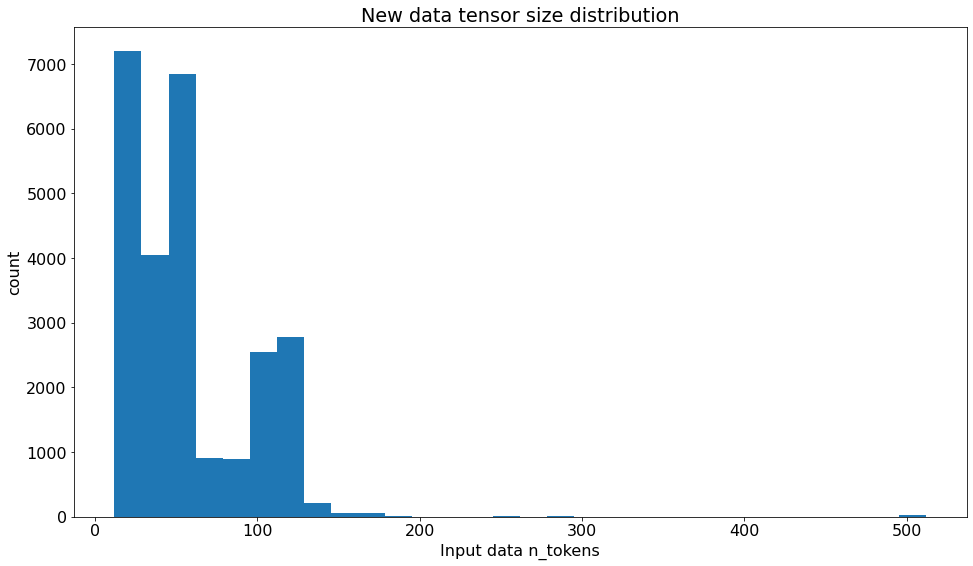

In [57]:
plt.rcParams["font.size"] = 16
fig,ax=plt.subplots(figsize=(16,9))
plt.hist(b, bins=30)
plt.xlabel("Input data n_tokens")
plt.ylabel("count")
plt.title("New data tensor size distribution")
plt.show()

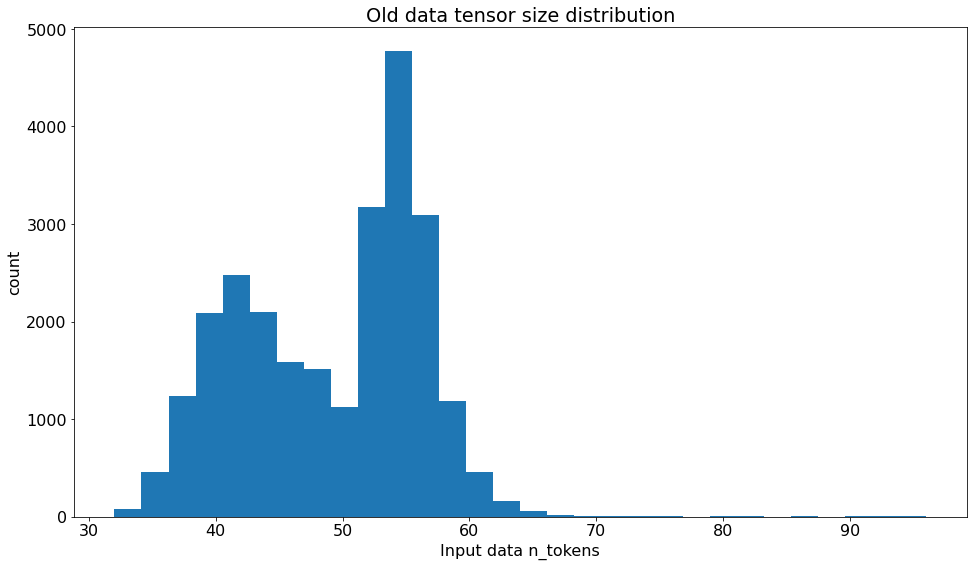

In [58]:
plt.rcParams["font.size"] = 16
fig,ax=plt.subplots(figsize=(16,9))
plt.hist(bold, bins=30)
plt.xlabel("Input data n_tokens")
plt.ylabel("count")
plt.title("Old data tensor size distribution")
plt.show()

In [7]:
# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.learning_rate = lr

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        outputs = model(**batch)
        loss = outputs.loss
        # Logging to TensorBoard by default
        print(loss)
        #self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.learning_rate)

        return optimizer

In [17]:
plmodel = LitAutoEncoder(model)

In [18]:
trainer = pl.Trainer(accelerator="gpu", devices=1, auto_select_gpus=True, auto_lr_find=True, accumulate_grad_batches=16)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Auto select gpus: [0]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
trainer.fit(model=plmodel, train_dataloaders=train_dataloader)
#lr_finder = trainer.tuner.lr_find(model=plmodel, train_dataloaders=train_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/tz/lib/python3.7/site-packages/transformers/optimization.py:348: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 2.8 B 
-----------------------------------------------------
131 M     Trainable params
2.7 B     Non-trainable params
2.8 B     Total params
11,399.029Total estimated model params size (MB)
/opt/conda/envs/tz/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 0:   0%|          | 0/1600 [00:00<?, ?it/s] 

RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 39.59 GiB total capacity; 37.34 GiB already allocated; 10.19 MiB free; 37.76 GiB reserved in total by PyTorch)

UsageError: Line magic function `%nvidia-smi` not found.


In [16]:
model.train()
for name, param in model.named_parameters():
    if name.startswith("encoder") or name.startswith("decoder"):
        param.requires_grad = False
    if name.startswith("shared") or name.startswith("lm_head"):
        t = torch.zeros(param.shape).to("cuda:0")
        t[-len(items) :, :] = 1
        param.register_hook(lambda grad: grad * t)


In [ ]:
last(model.children())


In [18]:
args

{'dataset_name': 'miniprompts002.parquet.gzip',
 'eval_name': 'miniprompts002_eval.parquet.gzip',
 'model_name_or_path': 'bigscience/T0_3B',
 'output_dir': '/home/gikok/output',
 'num_train_epochs': 1,
 'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 16,
 'freeze_encoder': True,
 'learning_rate': 1e+30,
 'parallelize': False,
 'seed': 42,
 'pad_to_max_length': False,
 'input_eos': False,
 'target_max_length': 256,
 'max_length': 512,
 'num_warmup_steps': 0,
 'debug': False,
 'lr_scheduler_type': 'linear',
 'num_shots': None,
 'weight_decay': 0.0,
 'gradient_checkpoint': False,
 'gradient_accumulation_steps': 1,
 'max_train_steps': None}

In [ ]:
t = torch.tensor(np.zeros((new_values[0][1].shape[0], new_values[0][1].shape[1])))


In [ ]:
t[-len(items) :, :] = 1


In [11]:
torch.cuda.empty_cache()

In [ ]:
l = 0
for mod in model.modules():
    l += 1
    if isinstance(mod, Embedding):
        if mod.num_embeddings == 38136:
            print(l, mod)
            print(type(mod))
            print(mod.num_embeddings)
            print("****************")


In [ ]:
l = 0
for mod in model.modules():
    print(mod)
    print("**************")


In [24]:
emb = list(model.named_parameters())[0][1]

In [26]:
abs(emb.grad[-101:-1])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])